# Microsoft Malware Prediction
W207 Final Project<br>

Gunnar Mein<br>
Andrew Morris<br>
Kevin Hartman

https://www.kaggle.com/c/microsoft-malware-prediction

## Contents

<ol>
    <li><a href='#Summary'>The Competition: Can you predict if a machine will soon be hit with malware?</a></li>
    <li><a href='#Definitions'>Definitions and Setup</a></li>
    <li><a href='#EDA'>Exploratory Data Analysis</a></li>
    <li><a href='#Cleaning'>Data Wrangling and Cleaning</a></li>
    <li><a href='#Preprocessing'>Encoding and Transformations</a></li>
    <li><a href='#FeatureSelection'>Feature Selection and Enginering</a></li>
    <li><a href='#ModelFitting'>Model Fitting and Evaluation</a></li>
    <li><a href='#Conclusion'>Review and Conclusion</a></li>
</ol>

We used the following classifiers that were covered in the course:

- **k Nearest Neighbors** (week 2)
- **Decision Trees**, as well as **Random Forests**, **AdaBoost**, and **Gradient Boosting** (week 4)
- **Logistic Regression** (week 5)
- **Neural Networks** (week 7)
- **PCA and Gaussian Mixture Models** (weeks 9 and 10)


We did not pursue Naive Bayes (week 3), Stochastic Gradient Descent (week 6) or Support Vector Machines (week 8)*, or due to time constraints, and because our EDA did not provide enough support to investigate these approaches.

\* Of note, I did run very limited LinearSVM() but the results showed the model just basically guessed all positives or all negatives and it was always half-right.

## Summary

<a href='#Contents'>[Back to top]</a>

## Definitions

<a href='#Contents'>[Back to top]</a>

In [1]:
# Import a bunch of libraries.

import re
import time
import gc

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

%matplotlib notebook
%matplotlib inline

import warnings
warnings.filterwarnings('ignore') #hide warnings that arise from missing glyphs, deprecations, etc.

In [2]:
#load with pre-informed data types for faster loading
def load_from_raw_data(filename):
    dtypes = {
        'MachineIdentifier':                                    'str',
        'ProductName':                                          'str',
        'EngineVersion':                                        'str',
        'AppVersion':                                           'str',
        'AvSigVersion':                                         'str',
        'IsBeta':                                               'int8',
        'RtpStateBitfield':                                     'float64',
        'IsSxsPassiveMode':                                     'int8',
        'DefaultBrowsersIdentifier':                            'float32',
        'AVProductStatesIdentifier':                            'float32',
        'AVProductsInstalled':                                  'float16',
        'AVProductsEnabled':                                    'float16',
        'HasTpm':                                               'int8',
        'CountryIdentifier':                                    'int16',
        'CityIdentifier':                                       'float32',
        'OrganizationIdentifier':                               'float16',
        'GeoNameIdentifier':                                    'float16',
        'LocaleEnglishNameIdentifier':                          'int16',
        'Platform':                                             'str',
        'Processor':                                            'str',
        'OsVer':                                                'str',
        'OsBuild':                                              'int16',
        'OsSuite':                                              'int16',
        'OsPlatformSubRelease':                                 'str',
        'OsBuildLab':                                           'str',
        'SkuEdition':                                           'str',
        'IsProtected':                                          'float16',
        'AutoSampleOptIn':                                      'int8',
        'PuaMode':                                              'str',
        'SMode':                                                'float16',
        'IeVerIdentifier':                                      'float16',
        'SmartScreen':                                          'str',
        'Firewall':                                             'float16',
        'UacLuaenable':                                         'float64', 
        'Census_MDC2FormFactor':                                'str',
        'Census_DeviceFamily':                                  'str',
        'Census_OEMNameIdentifier':                             'float32', 
        'Census_OEMModelIdentifier':                            'float32',
        'Census_ProcessorCoreCount':                            'float16',
        'Census_ProcessorManufacturerIdentifier':               'float16',
        'Census_ProcessorModelIdentifier':                      'float32', 
        'Census_ProcessorClass':                                'str',
        'Census_PrimaryDiskTotalCapacity':                      'float64', 
        'Census_PrimaryDiskTypeName':                           'str',
        'Census_SystemVolumeTotalCapacity':                     'float64', 
        'Census_HasOpticalDiskDrive':                           'int8',
        'Census_TotalPhysicalRAM':                              'float32',
        'Census_ChassisTypeName':                               'str',
        'Census_InternalPrimaryDiagonalDisplaySizeInInches':    'float32', 
        'Census_InternalPrimaryDisplayResolutionHorizontal':    'float32', 
        'Census_InternalPrimaryDisplayResolutionVertical':      'float32', 
        'Census_PowerPlatformRoleName':                         'str',
        'Census_InternalBatteryType':                           'str',
        'Census_InternalBatteryNumberOfCharges':                'float64', 
        'Census_OSVersion':                                     'str',
        'Census_OSArchitecture':                                'str',
        'Census_OSBranch':                                      'str',
        'Census_OSBuildNumber':                                 'int16',
        'Census_OSBuildRevision':                               'int32',
        'Census_OSEdition':                                     'str',
        'Census_OSSkuName':                                     'str',
        'Census_OSInstallTypeName':                             'str',
        'Census_OSInstallLanguageIdentifier':                   'float16',
        'Census_OSUILocaleIdentifier':                          'int16',
        'Census_OSWUAutoUpdateOptionsName':                     'str',
        'Census_IsPortableOperatingSystem':                     'int8',
        'Census_GenuineStateName':                              'str',
        'Census_ActivationChannel':                             'str',
        'Census_IsFlightingInternal':                           'float16',
        'Census_IsFlightsDisabled':                             'float16',
        'Census_FlightRing':                                    'str',
        'Census_ThresholdOptIn':                                'float16',
        'Census_FirmwareManufacturerIdentifier':                'float16',
        'Census_FirmwareVersionIdentifier':                     'float32',
        'Census_IsSecureBootEnabled':                           'int8',
        'Census_IsWIMBootEnabled':                              'float16',
        'Census_IsVirtualDevice':                               'float16',
        'Census_IsTouchEnabled':                                'int8',
        'Census_IsPenCapable':                                  'int8',
        'Census_IsAlwaysOnAlwaysConnectedCapable':              'float16',
        'Wdft_IsGamer':                                         'float16',
        'Wdft_RegionIdentifier':                                'float16',
        'HasDetections':                                        'int8'
        }

    df = pd.read_csv(filename, dtype=dtypes, engine='c')
    return df

In [3]:
# Custom-made class to assist with EDA on this dataset
# The code is generalizable. However, specific decisions on plot types were made because
# all our features are categorical
class Analyze:
    def __init__(self, df):
        self.df = df
        
    def print_eda_summary(self):
        #sns.set(rc={'figure.figsize':(10*2,16*8)})
        sns.set()
        i=0
        fig, ax = plt.subplots(nrows=round(len(self.df.columns)), ncols=2, figsize=(16,5*round(len(self.df.columns))))
        all_cols=[]
        for col in self.df.columns:
            #if col == 'MachineIdentifier': continue
            all_cols.append(col)
            max_len = self.df[col].nunique()
            if max_len > 10:
                max_len = 10
            g=sns.countplot(y=self.df[col].fillna(-1), hue=self.df['HasDetections'], order=self.df[col].fillna(-1).value_counts(dropna=False).iloc[:max_len].index, ax=ax[i][0])
            g.set_xlim(0,self.df.shape[0])
            plt.tight_layout()
            ax[i][0].title.set_text(col)
            ax[i][0].xaxis.label.set_visible(False)
            xlabels = ['{:,.0f}'.format(x) + 'K' for x in g.get_xticks()/1000]
            g.set_xticklabels(xlabels)
            ax[i][1].axis("off")
            # Basic info
            desc = self.df[col].describe()
            summary = "DESCRIPTION\n   Name: {:}\n   Type: {:}\n  Count: {:}\n Unique: {:}\nMissing: {:}\nPercent: {:2.3f}".format(
                desc.name.ljust(50), str(desc.dtype).ljust(10), self.df[col].count(), self.df[col].nunique(),
                ('yes' if self.df[col].hasnans else 'no'), (1-self.df[col].count()/self.df.shape[0])*100)
            ax[i][1].text(0, 1, summary, verticalalignment="top", family='monospace', fontsize=12)
            analysis=[]
            if self.df[col].dtype.name == 'object': 
                # additional analysis for categorical variables
                if len(self.df[col].str.lower().unique()) != len(self.df[col].unique()):
                    analysis.append("- duplicates from case\n")
                # look for HTML escape characters (&#x..;)
                # and unicode characters (searching for: anything not printable)
                self.df_bad = self.df[col][self.df[col].str.contains(r'[\x00-\x1f]|&#x\d\d;', regex=True, na=True)]
                if len(self.df_bad) - self.df.shape[0] - self.df[col].count()>0:
                    analysis.append("- illegal chars: {:}\n".format(len(self.df_bad) - self.df.shape[0] - self.df[col].count()))
                # find different capitalizations of "unknown"
                # if more than one present, need to read as string, turn to lowercase, then make categorical
                self.df_unknown = self.df[col].str.lower() == 'unknown'
                unknowns = self.df[col][self.df_unknown].unique()
                if len(unknowns) > 1:
                    analysis.append("- unknowns\n  {:}\n".format(unknowns))
                self.df[col] = self.df[col].astype('category')
                if len(''.join(analysis)) > 0:
                    ax[i][1].text(.5, .85, 'FINDINGS\n'+''.join(analysis), verticalalignment="top", family='monospace', fontsize=12)
            else:
                # Stats for numeric variables
                statistics = "STATS\n   Mean: {:5.4g}\n    Std: {:5.4g}\n    Min: {:5.4g}\n    25%: {:5.4g}\n    50%: {:5.4g}\n    75%: {:5.4g}\n    Max: {:5.4g}".format(
                    desc.mean(), desc.std(), desc.min(), desc.quantile(.25), desc.quantile(.5), desc.quantile(.75), desc.max())
                ax[i][1].text(.5, .85, statistics, verticalalignment="top", family='monospace', fontsize=12)

            # Top 5 and bottom 5 unique values or all unique values if < 10
            if self.df[col].nunique() <= 10:
                values = pd.DataFrame(list(zip(self.df[col].value_counts(dropna=False).keys().tolist(),
                                         self.df[col].value_counts(dropna=False).tolist())),
                                columns=['VALUES', 'COUNTS'])
                values = values.to_string(index=False)
                ax[i][1].text(0, .6, values, verticalalignment="top", family='monospace', fontsize=12)
            else:
                values = pd.DataFrame(list(zip(self.df[col].value_counts(dropna=False).iloc[:5].keys().tolist(),
                                         self.df[col].value_counts(dropna=False).iloc[:5].tolist())),
                                columns=['VALUES', 'COUNTS'])
                mid_row = pd.DataFrame({'VALUES':[":"],
                                        'COUNTS':[":"]})
                bot_values = pd.DataFrame(list(zip(self.df[col].value_counts(dropna=False).iloc[-5:].keys().tolist(),
                                         self.df[col].value_counts(dropna=False).iloc[-5:].tolist())),
                                columns=['VALUES', 'COUNTS'])
                values = values.append(mid_row)
                values = values.append(bot_values)
                values = values.to_string(index=False)
                ax[i][1].text(0, .6, values, verticalalignment="top", family='monospace', fontsize=12)
            i=i+1
        fig.show()

In [4]:
class Encoder:
    def __init__(self, df): #in_file):
        self.df = df #pd.read_csv(in_file, dtype=dtypes)
        #print("Completed read operation for", in_file)
        #self.reduce_mem()
        gc.collect()
        self.make_subsets(self.df)
        self.encode_it()
        self.transform_df(self.df, self.nominal_cols)
        self.std_norm()
        
    
    def reduce_mem(self, verbose=True):
        start_mem = self.df.memory_usage().sum() / 1024**2
        print('-- attempting to reduce memory. memory usage of dataframe is {:.2f} MB'.format(start_mem))

        for col in self.df.columns:
            col_type = self.df[col].dtype

            if col_type != object and str(col_type) != 'category':
                c_min = self.df[col].min()
                c_max = self.df[col].max()
                if str(col_type)[:3] == 'int':
                    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        self.df[col] = self.df[col].astype(np.int8)
                    elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        self.df[col] = self.df[col].astype(np.int16)
                    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        self.df[col] = self.df[col].astype(np.int32)
                    elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        self.df[col] = self.df[col].astype(np.int64)  
                # leave floats alone because the downcasting is messing up our mapped values
                #else:
                #    if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                #        df[col] = df[col].astype(np.float16)
                #    elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                #        df[col] = df[col].astype(np.float32)
                #    else:
                #        df[col] = df[col].astype(np.float64)
                else:
                    if str(col_type)[:5] != 'float':
                        self.df[col] = self.df[col].astype('category')

        end_mem = self.df.memory_usage().sum() / 1024**2
        print('-- memory usage after optimization is: {:.2f} MB'.format(end_mem))
        print('-- decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

        return self.df

    def make_subsets(self, df):
        print("-- making subsets ...")
        numerics = ['int8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64']
        self.numeric_cols = [c for c,v in self.df.dtypes.items() if v in numerics and c in self.df.columns]
        self.nominal_cols = [c for c in self.df.columns if (c not in self.numeric_cols)]
#         # Andrew - still need to fix this
#         self.nominal_cols.remove('SmartScreen')
        self.binary_cols = [c for c in self.df.columns if (self.df[c].nunique() == 2 and c not in self.nominal_cols)]
        self.unary_cols = [c for c in self.df.columns if (self.df[c].nunique() == 1 and c not in self.nominal_cols)]
        if "HasDetections" in df.columns:
            self.labels = df["HasDetections"].values
        print("-- subsets are complete")
        return

    def transform_df(self, in_df, nominal_cols):
        print("-- datatype transformation ...")
        le = preprocessing.LabelEncoder()
        tmp_df = in_df[nominal_cols].apply(le.fit_transform)
        for c in in_df.loc[:, in_df.dtypes == np.int8].columns:
            tmp_df[c] = in_df[c]
        for c in in_df.loc[:, in_df.dtypes == np.int16].columns:
            tmp_df[c] = in_df[c]
        for c in in_df.loc[:, in_df.dtypes == np.int32].columns:
            tmp_df[c] = in_df[c]
        for c in in_df.loc[:, in_df.dtypes == np.int64].columns:
            tmp_df[c] = in_df[c]
        for c in in_df.loc[:, in_df.dtypes == np.float16].columns:
            tmp_df[c] = in_df[c]
        for c in in_df.loc[:, in_df.dtypes == np.float32].columns:
            tmp_df[c] = in_df[c]
        for c in in_df.loc[:, in_df.dtypes == np.float64].columns:
            tmp_df[c] = in_df[c]
        for c in in_df[in_df.select_dtypes(bool).columns]:
            tmp_df[c] = in_df[c]
        self.df = tmp_df
        print("-- completed transforming dtypes")
        return

    def std_norm(self):
        print("-- scaling ...")
        col_to_std = ['AVProductStatesIdentifier',
                      'CountryIdentifier',
                      'CityIdentifier',
                      'GeoNameIdentifier',
                      'LocaleEnglishNameIdentifier',
                      'OsBuild',
                      'IeVerIdentifier',
                      'Census_OEMNameIdentifier',
                      'Census_OEMModelIdentifier',
                      'Census_ProcessorCoreCount',
                      'Census_ProcessorModelIdentifier',
                      'Census_PrimaryDiskTotalCapacity',
                      'Census_SystemVolumeTotalCapacity',
                      'Census_TotalPhysicalRAM',
                      'Census_InternalPrimaryDiagonalDisplaySizeInInches',
                      'Census_InternalPrimaryDisplayResolutionHorizontal',
                      'Census_InternalPrimaryDisplayResolutionVertical',
                      'Census_InternalBatteryNumberOfCharges',
                      'Census_OSBuildNumber',
                      'Census_OSInstallLanguageIdentifier',
                      'Census_OSUILocaleIdentifier',
                      'Census_FirmwareManufacturerIdentifier',
                      'Census_FirmwareVersionIdentifier',
                      'Wdft_RegionIdentifier',
                      'OsBuildLab_major',
                      'OsBuildLab_minor',
                      'OsBuildLab_platform',
                      'OsBuildLab_release',
                      'OsBuildLab_build2']
        scaled_features = self.df.copy()
        features = scaled_features[col_to_std]
        scaler = StandardScaler().fit(features.values)
        features = scaler.transform(features.values)
        scaled_features[col_to_std] = features
        self.df = scaled_features
        print("-- completed standardization and normalization")
        return
    
    def encode_it(self):
        print("-- label encoding ...")
        le = preprocessing.LabelEncoder()
        for n in self.nominal_cols:
            #print(" ...",n)
            self.df[n] = le.fit_transform(self.df[n])
        print("-- completed label encoding")
        return
    
    def get_encoded_data(self):
        return self.df

In [5]:
# function to create a mini set from the supplied criteria (n, features, labels)
def generate_mini(n, features, labels):
    sample_size = n / features.shape[0]
    reserved_size = 1-sample_size
    X_mini, X_rest, y_mini, y_rest = train_test_split(features, labels, stratify=labels, test_size=reserved_size, random_state=0)
    return X_mini, X_rest, y_mini, y_rest

In [6]:
# function to create stratified train, dev and validate sets from supplied ratios 
def generate_train_dev_validate_sets(train_ratio, test_ratio, features, labels):
    reserved_size = 1-train_ratio
    X_train, X_rest, y_train, y_rest =  \
        train_test_split(features, labels, stratify=labels, test_size=reserved_size, random_state=0)
    reserved_size = 1 - (test_ratio / reserved_size)
    X_dev, X_validate, y_dev, y_validate = \
        train_test_split(X_rest, y_rest, stratify=y_rest, test_size=reserved_size, random_state=0)
    return X_train, X_dev, X_validate, y_train, y_dev, y_validate

In [7]:
#
# function for saving encoded frames
#
def save_encoded_files(df, name):
    
    # save the file
    df.to_csv("data/"+name+"_encoded.csv", index=False)
    

In [8]:
# helper function for generating our dtypes for loading the file back when we need it
def dump_final_types(df):
    for dtype in df.dtypes.items():
        print("'{:} '{:}',".format((dtype[0] + "':").ljust(54), dtype[1]))

## EDA

<a href='#Contents'>[Back to top]</a>

Raw notes:

Analysis workbook for seaborn plots

### Analyze the datasets

In [9]:
train_df = load_from_raw_data("data/train.csv") # replace this with data/train.csv
test_df = load_from_raw_data("data/test.csv") # replace this with data/test.csv
test_df['HasDetections'] = np.int8(2)
full_df = pd.concat([train_df, test_df])

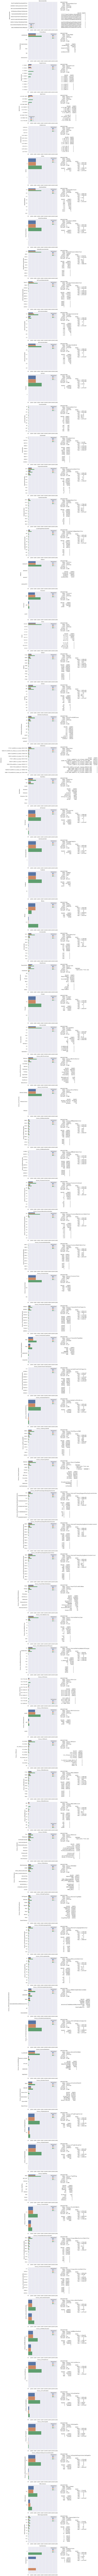

In [10]:
analyzer = Analyze(full_df)
analyzer.print_eda_summary()

Notes: (to inform further cleaning)
* Fields with largely missing values:
 * PuaMode - missing 99.9% of the data - remove
 * Census_ProcessorClass - 99.5% missing - remove
 * DefaultBrowsersIdentifier - 95% missing - probably would correlate well with malware but its all missing - remove 
 * Census_IsFlightingInternal - 83 missing (21 are 1s and rest are 0) - remove
 * Census_InternalBatteryType - 70% missing - battery correlates to malware how? - remove
* Binary fields
 * Census_IsWIMBootEnabled - It is 0 or missing. One value is set to 1. Recode the 1 as a "missing" and make this a binary field?
 * Census_IsFlightsDisabled - Mostly 0s. 2% are missing. 88 are 1s. Recode the 1 as "missing" and then it becomes a binary field?
 * Census_IsPortableOperatingSystem - Mostly 0s - remove
 * IsBeta - mostly 0s. 67 are 1s. - remove
 * AutoSampleOptIn - Mostly 0s. - remove
* Other fields
 * UacLuaenable - Mostly 1s. Zero out the rest and turn into a binary field.
 * AvProductsInstalled - Bin 4,5,6 and 7 into one bin. Move 0 and the missings together.
 * AvProductsEnabled - Bin 4 and 5 together. 
 * RtpStateBitField - Bin 3, 1 and 35 together with the missing category.
 * SmartScreen - Bin the garbage and low frequency values with the missing category. Correct spellings on the others.
 * Census_ProcessorCoreCount - could bin but need to probe in further to see how
 * Census_ProcessorManufacturerIdentifier - bin 10, 3, 9, 7 and 4 with the missing category.
 * Census_InternalPrimaryDiagonalDisplaySizeInInches - bin these by real inches w/o the fractions - need to probe in further
 * Census_InternalPrimaryDisplayResolutionHorizontal - same as above
 * Census_InternalPrimaryDisplayResolutionVertical - same as above
 * Census_GenuineStateName - Bin TAMPERED with UNKNOWN
 * Census_FlightRing - Bin Invalid with Unknown
 * Census_PrimaryDiskTotalCapacity - Bin this by range?
 * Census_SystemVolumeTotalCapacity - Same as above
 * Census_TotalPhysicalRam - Same as above
 * Census_ChassisTypeName - Look into binning
 
 

## Cleaning

<a href='#Contents'>[Back to top]</a>

Raw notes:

TODO: Include the cleaning portion of the wrangler notebook

To clean the SmartScreen and turn into bins:

In [11]:
def clean_data(df):   
    #
    # make all strings lower case
    # get rid of hex char codes, keep the actual code number
    #
    
    char_treatment = [
        'AvSigVersion',
        'SmartScreen',
        'Census_InternalBatteryType'
    ]
    
    case_treatment = [
        'SmartScreen',
        'Census_ChassisTypeName',
        'Census_OSEdition',
        'Census_PowerPlatformRoleName',
        'Census_GenuineStateName'
    ]
    
    print("-- replacing weird characters ...")
    for col in char_treatment:
        if df[col].dtype.name == 'object':
            df[col] = df[col].str.replace(r'&#x(\d\d);', '\1', regex=True)
            df[col] = df[col].str.replace(r'[\x00-\x1f]', '', regex=True)
            
    print("-- lower-casing where appropriate ...")
    for col in case_treatment:
        if df[col].dtype.name == 'object':
            df[col] = df[col].str.lower()
             
    #
    # Fix SmartScreen discrepencies
    # TODO: Decide what to do with the garbage fields
    #           
    df.replace({'SmartScreen':
        {'Enabled':'on',
         'RequiredAdmin':'requireadmin',
         'of':'off',
         'Promt':'prompt',
         'Promprt':'prompt'}})
            
    #
    # make strings into categories
    #
    
    categories = [
        'SmartScreen',
        'Census_InternalBatteryType',
        'Census_ChassisTypeName',
        'Census_OSEdition'
    ]
    
    print("-- making categories from strings that needed massaging ...")
    for col in categories:
        df[col] = df[col].astype('category')


        
    #
    # add 'unknown' categories where necessary and replace the NAs
    # ADD COLUMNS NAMES HERE TO HAVE THEIR CATEGORIES AUGMENTED AND NAS FILLED WITH 'unknown'
    #
    
    categories = [
        'PuaMode',
        'SmartScreen',
        'Census_ProcessorClass',
        'Census_PrimaryDiskTypeName',  # ['HDD' 'SSD' 'UNKNOWN' 'Unspecified']
        'Census_InternalBatteryType',
        'Census_OSEdition',
        'Census_PowerPlatformRoleName', # also had 'unknown' as well as Nas
        'Census_GenuineStateName',       # and this one too
        'Census_ChassisTypeName'
        
    ]

    print("-- adding categories ..")
    for col in categories:
        df[col].cat.add_categories(['unknown'], inplace=True)
        df[col].fillna('unknown', inplace=True)
    # add one manually because it needs a special unknown value
    df["OsBuildLab"].cat.add_categories(["0.0.-.-.0-0"], inplace=True)
    df["OsBuildLab"].fillna("0.0.-.-.0-0", inplace=True)
    # and this one already had some 'unknown' values
    #df['Census_ChassisTypeName'].fillna('unknown', inplace=True)



    #
    # flag and fill selected NAs
    # ADD COLUMN NAMES HERE IN nafill TO HAVE COLUMNS FLAGGED AND FILLED WITH PROVIDED VALUES
    #
    
    print("-- replacing selected NA values")
    nafill = {
        "RtpStateBitfield":0,
        "DefaultBrowsersIdentifier":0,
        "AVProductStatesIdentifier":0,
        "AVProductsInstalled":0,
        "AVProductsEnabled":0,
        "CityIdentifier":0,
        "OrganizationIdentifier":0,
        "GeoNameIdentifier":0,
        "IsProtected":0,
        "SMode":0,
        "IeVerIdentifier":0,
        "Firewall":0,
        "UacLuaenable":0,
        "Census_OEMNameIdentifier":0,
        "Census_OEMModelIdentifier":0,
        "Census_ProcessorCoreCount":0,
        "Census_ProcessorManufacturerIdentifier":0,
        "Census_ProcessorModelIdentifier":0,
        "Census_PrimaryDiskTotalCapacity":0,
        "Census_SystemVolumeTotalCapacity":0,
        "Census_TotalPhysicalRAM":0,
        "Census_InternalPrimaryDiagonalDisplaySizeInInches":0,
        "Census_InternalPrimaryDisplayResolutionHorizontal":0,
        "Census_InternalPrimaryDisplayResolutionVertical":0,
        "Census_InternalBatteryNumberOfCharges":0,
        "Census_OSInstallLanguageIdentifier":0,
        "Census_IsFlightingInternal":0,
        "Census_IsFlightsDisabled":0,
        "Census_ThresholdOptIn":0,
        "Census_FirmwareManufacturerIdentifier":0,
        "Census_IsWIMBootEnabled":0,
        "Census_IsVirtualDevice":0,
        "Census_IsAlwaysOnAlwaysConnectedCapable":0,
        "Wdft_IsGamer":0,
        "Wdft_RegionIdentifier":0,
        "Census_FirmwareVersionIdentifier":0
    }

    for col in nafill:
        df[col+'_wasna'] = df[col].isna()
    df.fillna(value=nafill, inplace=True)
    
    #
    # then some of these columns can become ints, not floats
    #

    print("-- converting columns to int ...")
    df['RtpStateBitfield'] = df['RtpStateBitfield'].astype(np.uint8)

    #
    # deal with version numbers
    #
    
    print("-- mapping version numbers ...")
    def map_OsVer(df,col):
        df_split = df[col].astype(str).str.split(".", n=3, expand=True)
        df[col+'_major'] = df_split[0].astype(np.int16)
        df[col+'_minor'] = df_split[1].astype(np.int16)
        df[col+'_build1'] = df_split[2].astype(np.int16)
        df[col+'_build2'] = df_split[3].astype(np.int16)
        # the "combined" column is an attempt at making an orginal out of the four values
        df[col+'_combined'] = 10000.0*df[col+'_major']+100.0*df[col+'_minor']+1.0*(df[col+'_build1'])+(df[col+'_build2'])/1000.0

    # e.g. 10.0.10240.16397
    def map_CensusOSVersion(df,col):
        df_split = df[col].astype(str).str.split(".", n=3, expand=True)
        df[col+'_major'] = df_split[0].astype(np.int16)
        df[col+'_minor'] = df_split[1].astype(np.int16)
        df[col+'_build1'] = df_split[2].astype(np.int16)
        df[col+'_build2'] = df_split[3].astype(np.int16)
        # the "combined" column is an attempt at making an orginal out of the four values
        df[col+'_combined'] = 1000000.0*df[col+'_major']+df[col+'_minor']*10000+(df[col+'_build1'])+(df[col+'_build2'])/100000.0

    # e.g. 1.235.2586.0
    def map_AvSigVersion(df,col):
        df_split = df[col].astype(str).str.split(".", n=3, expand=True)
        df[col+'_major'] = df_split[0].astype(np.int16)
        if df_split[1] == '2&#x17;3':
            df[col+'_minor'] = 217 #data correction
        else:
            df[col+'_minor'] = df_split[1].astype(np.int16)
        df[col+'_build1'] = df_split[2].astype(np.int16)
        df[col+'_build2'] = df_split[3].astype(np.int16)
        # the "combined" column is an attempt at making an orginal out of the four values
        df[col+'_combined'] = 10000.0*df[col+'_major']+df[col+'_minor']+(df[col+'_build1'])/10000.0+(df[col+'_build2'])/10000000.0


    # e.g. 4.12.17007.18022
    def map_AppVersion(df,col):
        df_split = df[col].astype(str).str.split(".", n=3, expand=True)
        df[col+'_major'] = df_split[0].astype(np.int16)
        df[col+'_minor'] = df_split[1].astype(np.int16)
        df[col+'_build1'] = df_split[2].astype(np.int16)
        df[col+'_build2'] = df_split[3].astype(np.int16)
        # the "combined" column is an attempt at making an orginal out of the four values
        df[col+'_combined'] = 10000000.0*df[col+'_major']+100000.0 * df[col+'_minor']+1.0*(df[col+'_build1'])+(df[col+'_build2'])/100000.0

    # e.g. 1.1.12902.0
    def map_EngineVersion(df,col):
        df_split = df[col].astype(str).str.split(".", n=3, expand=True)
        df[col+'_major'] = df_split[0].astype(np.int16)
        df[col+'_minor'] = df_split[1].astype(np.int16)
        df[col+'_build1'] = df_split[2].astype(np.int16)
        df[col+'_build2'] = df_split[3].astype(np.int16)
        # the "combined" column is an attempt at making an orginal out of the four values
        df[col+'_combined'] = 100000000.0*df[col+'_major']+1000000.0*df[col+'_minor']+1.0*(df[col+'_build1'])+(df[col+'_build2'])/10000.0

    def map_OsBuildLab(df, col):
        series = df[col].astype(str).str.replace('*', '.', regex=False)
        df_split = series.str.split(".", n=4, expand=True)
        df[col+'_major'] = df_split[0].astype(np.int16)
        df[col+'_minor'] = df_split[1].astype(np.int16)
        df[col+'_platform'] = df_split[2].astype('category')
        df[col+'_release'] = df_split[3].astype('category')
        df_build = df_split[4].str.split("-", n=1, expand=True)
        df[col+'_build1'] = df_build[0].astype(np.int32)
        df[col+'_build2'] = df_build[1].astype(np.int32)
        # the "combined" column is an attempt at making an orginal out of the four values
        df[col+'_combined'] = 1000000.0*df['OsBuildLab_major']+10.0*df['OsBuildLab_minor']+df['OsBuildLab_build1']/100000.0+df['OsBuildLab_build2']/10000000000.0
        df_split = None
        df_build = None

    map_EngineVersion(df, "EngineVersion")
    map_AppVersion(df, "AppVersion")
    map_AvSigVersion(df, "AvSigVersion")
    map_CensusOSVersion(df, "Census_OSVersion")
    map_OsVer(df, "OsVer")
    map_OsBuildLab(df, "OsBuildLab")    
    
    gc.collect()
    
    return df

In [12]:
cleaned_df = clean_data(full_df)

-- replacing weird characters ...
-- lower-casing where appropriate ...
-- making categories from strings that needed massaging ...
-- adding categories ..
-- replacing selected NA values
-- converting columns to int ...
-- mapping version numbers ...


ValueError: invalid literal for int() with base 10: '2&#x17;3'

## Preprocessing

<a href='#Contents'>[Back to top]</a>

Raw notes:

Encoding portion of wrangler and description of what we did and why we did it

In [ ]:
encoded_full_df = Encoder(cleaned_df).get_encoded_data()

Split the test and train segments back off

In [ ]:
encoded_train_df = encoded_full_df[encoded_full_df['HasDetections'] != 2]
encoded_test_df = encoded_full_df[encoded_full_df['HasDetections'] == 2]
encoded_test_df = encoded_test_df.drop(columns='HasDetections')

Create mini-train sets (and optionally save)

In [ ]:
save_data=True

start = time.time()

In [ ]:
# generate stratified data sets using supplied ratios to create the sets
df_train, df_dev, df_validate, train_labels, dev_labels, validate_labels = \
    generate_train_dev_validate_sets(.7, .15, encoded_train_df, encoded_train_df['HasDetections'])

In [ ]:
#
# create mini_ files for model development
#
mini_ratio = .05

mini_train, remaining, mini_train_labels, remaining_labels = \
    generate_mini(df_train.shape[0]*mini_ratio, df_train, df_train['HasDetections'])

mini_dev, remaining, mini_dev_labels, remaining_labels = \
    generate_mini(df_dev.shape[0]*mini_ratio, df_dev, df_dev['HasDetections'])

mini_validate, remaining, mini_validate_labels, remaining_labels = \
    generate_mini(df_validate.shape[0]*mini_ratio, df_validate, df_validate['HasDetections'])

In [ ]:
print("shape of mini_train:",mini_train.shape)
print("shape of mini_dev:",mini_dev.shape)
print("shape of mini_validate:",mini_validate.shape)
print("\nchecking symmetric difference between mini_dev and mini_train:", len(set(mini_train['MachineIdentifier']).symmetric_difference(mini_dev['MachineIdentifier'])))
print("-- total unique machine ids after recombining both sets:", pd.concat([mini_train['MachineIdentifier'], mini_dev['MachineIdentifier']]).nunique())
print("-- original length of mini_dev + length of mini_train:", mini_dev.shape[0] + mini_train.shape[0])
print("\nchecking symmetric difference between mini_validate and mini_train:", len(set(mini_train['MachineIdentifier']).symmetric_difference(mini_validate['MachineIdentifier'])))
print("-- total unique machine ids after recombining both sets:", pd.concat([mini_train['MachineIdentifier'], mini_validate['MachineIdentifier']]).nunique())
print("-- original length of mini_validate + length of mini_train:", mini_validate.shape[0] + mini_train.shape[0])
print("\nchecking symmetric difference between mini_dev and mini_validate:", len(set(mini_dev['MachineIdentifier']).symmetric_difference(mini_validate['MachineIdentifier'])))
print("-- total unique machine ids after recombining both sets:", pd.concat([mini_dev['MachineIdentifier'], mini_validate['MachineIdentifier']]).nunique())
print("-- original length of mini_dev + length of mini_validate:", mini_validate.shape[0] + mini_dev.shape[0])
print("\ndone making mini sets")
print("seconds elapsed:", time.time()-start)

In [ ]:
#
# save encoded mini files
# save function will add "data/" and "_encoded.csv"
#

if save_data:
    print("saving mini_train_encoded ...")
    save_encoded_files(mini_train, "mini_train")
    print("saving mini_dev_encoded ...")
    save_encoded_files(mini_dev, "mini_dev")
    print("saving mini_validate_encoded ...")
    save_encoded_files(mini_validate, "mini_validate")
    print("done saving mini files")
    print("seconds elapsed:", time.time()-start)



In [ ]:
#
# save encoded full files
# save function will add "data/" and "_encoded.csv"
#

if save_data:
    print("saving train_encoded ...")
    save_encoded_files(df_train, "train")
    print("done saving encoded train file")

    print("saving dev_encoded ...")
    save_encoded_files(df_dev, "dev")
    print("done saving encoded dev file")

    print("saving validate_encoded ...")
    save_encoded_files(df_validate, "validate")
    print("done saving encoded validate file")


In [ ]:
#
# save large test dataset
#

if save_data:
    print("saving encoded large test data ...")
    save_encoded_files(encoded_test_df, "test")
    print("done saving encoded files")
    print("seconds elapsed:", time.time()-start)
    
print("all done.")

## FeatureSelection

<a href='#Contents'>[Back to top]</a>

Raw notes:

Selection of Features using correlation, corplot analysis, and Gunnar's incremental trick

Selection of Features using SelectFromModel

Selection of Features using PCA (with GMM)

Selection of Features using Ridge Regression (not sure if we want to include)

In [ ]:
#todo: rerun after encoding
sns.set(rc={'figure.figsize':(100,100)})
sns.heatmap(encoded_full_df.corr(), cmap='RdBu_r', annot=True, center=0.0)

## ModelFitting

<a href='#Contents'>[Back to top]</a>

## Conclusion

<a href='#Contents'>[Back to top]</a>

In [ ]:
pd.set_option('display.max_rows', None)
encoded_full_df.describe().transpose()